### Импорт библиотек и моделей ###

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance
import joblib
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Первичный анализ данных  ###

In [7]:
df = pd.read_csv("S06-hw-dataset-02.csv")
print("Первые пять строк данных\n")
display(df.head())
print("\nОбщая информация о данных\n")
print(df.info())
print("\nОсновная статистика\n")
display(df.describe())
print("\nРаспределение переменной 'target'\n")
target_dist = df['target'].value_counts(normalize=True)
print(target_dist)
missing = df.isnull().sum().sum()
print("\nЧисло пропусков в данных: {missing}\n")
X = df.drop(columns=['id', 'target'])  # признаки
y = df['target']  # целевая переменная
print(f"\nРазмер матрицы признаков X: {X.shape}")
print(f"Размер вектора таргета y: {y.shape}")

Первые пять строк данных



,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0



Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-nul

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000



Распределение переменной 'target'

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64

Число пропусков в данных: {missing}


Размер матрицы признаков X: (18000, 37)
Размер вектора таргета y: (18000,)


### Train / test ###

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"Размер обучающей выборки: {X_train.shape[0]} объектов")
print(f"Размер тестовой выборки (X_test): {X_test.shape[0]} объектов")
print("\nРаспределение классов в обучающей выборке\n")
train_dist = y_train.value_counts(normalize=True)
print(train_dist)
print("\nРаспределение классов в тестовой выборке (y_test):")
test_dist = y_test.value_counts(normalize=True)
print(test_dist)

Размер обучающей выборки: 14400 объектов
Размер тестовой выборки (X_test): 3600 объектов

Распределение классов в обучающей выборке

target
0    0.737361
1    0.262639
Name: proportion, dtype: float64

Распределение классов в тестовой выборке (y_test):
target
0    0.7375
1    0.2625
Name: proportion, dtype: float64


Стратификация гарантирует схожее распределние классов в тестовой и обучающей выборке. 

Фиксированное значение random_state обеспечивает воспроизводимость программы: при разных запусках мы получим те же результаты.

### Baseline ###

In [10]:
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
acc_dummy = accuracy_score(y_test, y_pred_dummy)  # доля верных ответов
f1_dummy = f1_score(y_test, y_pred_dummy)
print("Dummy Classifier - минимальный ориентир")
print(f'accuracy: {acc_dummy:.4f}')
print(f'f1: {f1_dummy:.4f}')

Dummy Classifier - минимальный ориентир
accuracy: 0.7375
f1: 0.0000


accuracy = 0.7375 - доля самого частого класса в данных
f1 = 0.0000 - модель не находит редкий класс 1
Данная модель - минимальный ориентир, любая следующая модель должна быть лучше.

In [11]:
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000
    ))
])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)
print("LogisticRegression - линейная модель")
print(f'accuracy: {acc_lr:.4f}')
print(f'f1: {f1_lr:.4f}')
print(f'roc-auc: {roc_lr:.4f}')


LogisticRegression - линейная модель
accuracy: 0.8119
f1: 0.5607
roc-auc: 0.7977


accuracy = 0.8119 - улучшила показатель Dummy
f1 = 0.5607 - модель находит объекты класса 1
roc-auc = 0.7977 - модель различает классы
Логистическая регрессия работает лучше случайного угадывания, но её возможности ограничены из-за наличия нелинейных зависимостей.

### Модели ###

#### DecisionTreeClassifier ####

In [15]:
tree_unconstrained = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=None,
    min_samples_leaf=1
)
tree_unconstrained.fit(X_train, y_train)
y_pred_train_unconstrained = tree_unconstrained.predict(X_train)
y_pred_test_unconstrained = tree_unconstrained.predict(X_test)
acc_train_unconstrained = accuracy_score(y_train, y_pred_train_unconstrained)
acc_test_unconstrained = accuracy_score(y_test, y_pred_test_unconstrained)
print("Дерево без ограничений")
print(f"Accuracy на train: {acc_train_unconstrained:.4f}")
print(f"Accuracy на test:  {acc_test_unconstrained:.4f}")
print(f"Разница: {acc_train_unconstrained - acc_test_unconstrained:.4f}")

Дерево без ограничений
Accuracy на train: 1.0000
Accuracy на test:  0.8083
Разница: 0.1917


In [17]:
tree_param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 5, 10],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]
}
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)  # кросс-валидация
tree_grid = GridSearchCV(  # гиперпараметры
    tree,
    tree_param_grid,
    cv=cv,
    scoring='roc_auc',   
    n_jobs=-1,          
    verbose=0            
)
tree_grid.fit(X_train, y_train)
print(f"\nЛучшие параметры дерева: {tree_grid.best_params_}")
print(f"Лучший ROC-AUC на CV: {tree_grid.best_score_:.4f}")
y_pred_tree = tree_grid.predict(X_test)
y_proba_tree = tree_grid.predict_proba(X_test)[:, 1]

acc_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)
roc_tree = roc_auc_score(y_test, y_proba_tree)

print("\nДерево с ограничениями")
print(f"accuracy: {acc_tree:.4f}")
print(f"f1: {f1_tree:.4f}")
print(f"roc-auc:  {roc_tree:.4f}")
print(f"\nУлучшение ROC-AUC по сравнению с LogisticRegression: {roc_tree - 0.7977:.4f}")


Лучшие параметры дерева: {'ccp_alpha': 0.0, 'max_depth': 8, 'min_samples_leaf': 10}
Лучший ROC-AUC на CV: 0.8295

Дерево с ограничениями
accuracy: 0.8289
f1: 0.6193
roc-auc:  0.8288

Улучшение ROC-AUC по сравнению с LogisticRegression: 0.0311


Дерево без ограничений на обучающей выборке достигает accuracy = 1, оно запоминает аднные и переобучается. На тестовой выборке accuracy падает до 0.8083.

После контроля сложности дерево становится стабильнее, а roc-auc стал выше, чем у логистической регрессии, значит дерево лучше справилось с нелинейными зависимостями.

Без контроля сложности дерево становится бесполезным, но с правильными параметрами превосходит линейную модель.

#### RandomForestClassifier ####

In [19]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_estimators=100 
)
rf_param_grid = {
    'max_depth': [5, 8, 10, None],        
    'min_samples_leaf': [1, 2, 5, 10],   
    'max_features': ['sqrt', 'log2', 0.5] 
}
rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=0
)
rf_grid.fit(X_train, y_train)
print("Random Forest")
print(f"Лучшие параметры: {rf_grid.best_params_}")
print(f"Лучший roc-auc на CV: {rf_grid.best_score_:.4f}")
y_pred_rf = rf_grid.predict(X_test)
y_proba_rf = rf_grid.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_size = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\naccuracy: {acc_rf:.4f}")
print(f"f1: {f1_rf:.4f}")
print(f"roc-auc:  {roc_rf:.4f}")
print(f"\nУлучшение roc-auc по сравнению с деревом: {roc_rf - 0.8288:.4f}")
print(f"\nУлучшение roc-auc по сравнению с LogisticRegression: {roc_rf - 0.7977:.4f}")

Random Forest
Лучшие параметры: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1}
Лучший roc-auc на CV: 0.9260

accuracy: 0.8889
f1: 0.7491
roc-auc:  0.9260

Улучшение roc-auc по сравнению с деревом: 0.0972

Улучшение roc-auc по сравнению с LogisticRegression: 0.1283


Random forest превосходит дерево и линейную модель, это значит, что ансамбль моделей лучше справляется с нелинейными моделями и шумом.
Он не переобучается так сильно, как одно дерево, и даёт лучшее качество среди всех рассмотренных моделей до бустинга.

#### HistGradientBoostingClassifier ####

In [20]:

boost = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    max_iter=200
)
boost_param_grid = {
    'learning_rate': [0.05, 0.1, 0.2], 
    'max_depth': [3, 5, 7],            
    'min_samples_leaf': [10, 20, 50]      
}
boost_grid = GridSearchCV(
    boost,
    boost_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)
boost_grid.fit(X_train, y_train)
print("HistGradientBoostingClassifier")
print(f"Лучшие параметры: {boost_grid.best_params_}")
print(f"Лучший roc-auc на CV: {boost_grid.best_score_:.4f}")
y_pred_boost = boost_grid.predict(X_test)
y_proba_boost = boost_grid.predict_proba(X_test)[:, 1]
acc_boost = accuracy_score(y_test, y_pred_boost)
f1_boost = f1_score(y_test, y_pred_boost)
roc_boost = roc_auc_score(y_test, y_proba_boost)
print(f"\naccuracy: {acc_boost:.4f}")
print(f"f1: {f1_boost:.4f}")
print(f"roc-auc:  {roc_boost:.4f}")
print(f"\nУлучшение roc-auc по сравнению с деревом: {roc_boost - 0.8288:.4f}")
print(f"Улучшение roc-auc по сравнению с LogisticRegression: {roc_boost - 0.7977:.4f}")

HistGradientBoostingClassifier
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 50}
Лучший roc-auc на CV: 0.9305

accuracy: 0.9081
f1: 0.8101
roc-auc:  0.9321

Улучшение roc-auc по сравнению с деревом: 0.1033
Улучшение roc-auc по сравнению с LogisticRegression: 0.1344


HistGradientBoosting показал лучшее качество среди всех моделей, это  говорит о том, что градиентный бустинг лучше всего справляется с нелинейными зависимостями и шумом

In [23]:
from sklearn.ensemble import StackingClassifier

base_models = [
    ('tree', DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=5, random_state=RANDOM_STATE)),
    ('boost', HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=5, random_state=RANDOM_STATE))
]

meta_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,             
    n_jobs=-1
)
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_test)
y_proba_stack = stacking.predict_proba(X_test)[:, 1]
acc_stack = accuracy_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)
roc_stack = roc_auc_score(y_test, y_proba_stack)
print("StackingClassifier")
print(f"Accuracy: {acc_stack:.4f}")
print(f"F1-score: {f1_stack:.4f}")
print(f"ROC-AUC:  {roc_stack:.4f}")

StackingClassifier
Accuracy: 0.8964
F1-score: 0.7894
ROC-AUC:  0.9233


Стекинг (0.9233) не превзошёл бустинг (0.9321), это говорит о том, что комбинация моделей через метамодель работает, но не всегда превосходит лучшую отдельную модель.

### Графики и интерпретация ###

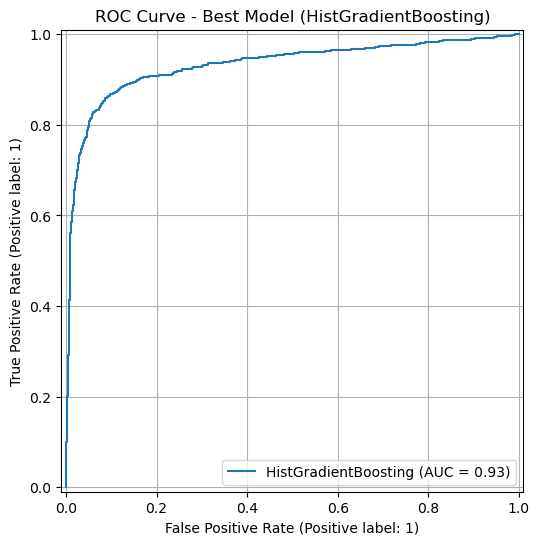

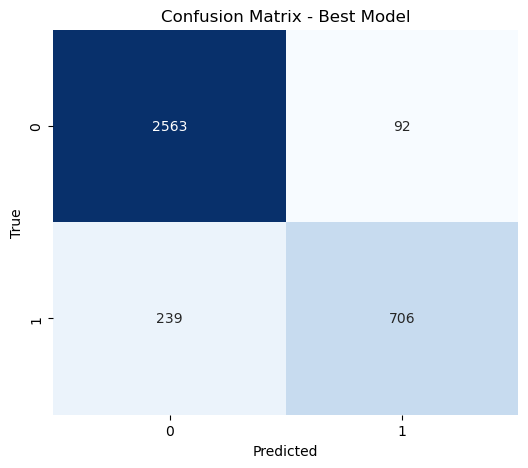

Top 10 Important Features
1. f16: 0.0705 ± 0.0037
2. f01: 0.0271 ± 0.0025
3. f07: 0.0235 ± 0.0023
4. f08: 0.0177 ± 0.0015
5. f19: 0.0158 ± 0.0014
6. f30: 0.0148 ± 0.0011
7. f15: 0.0116 ± 0.0009
8. f23: 0.0103 ± 0.0022
9. f13: 0.0094 ± 0.0007
10. f05: 0.0083 ± 0.0008


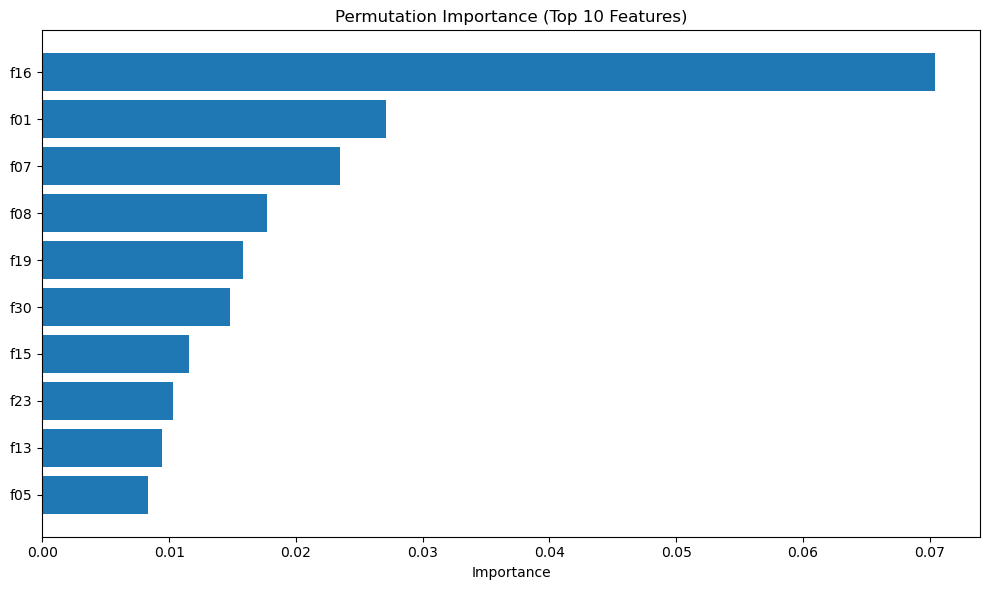

In [26]:
best_model = boost_grid 

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax, name="HistGradientBoosting")
plt.title("ROC Curve - Best Model (HistGradientBoosting)")
plt.grid(True)
plt.savefig("artifacts/figures/roc_curve.png", dpi=150, bbox_inches='tight')
plt.show()

y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("artifacts/figures/confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

perm_imp = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,      
    random_state=RANDOM_STATE,
    n_jobs=-1              
)

indices = np.argsort(perm_imp.importances_mean)[::-1]
print("Top 10 Important Features")
for i in range(10):
    feature_name = X.columns[indices[i]]
    importance_mean = perm_imp.importances_mean[indices[i]]
    importance_std = perm_imp.importances_std[indices[i]]
    print(f"{i+1}. {feature_name}: {importance_mean:.4f} ± {importance_std:.4f}")
plt.figure(figsize=(10, 6))
plt.barh(range(10), perm_imp.importances_mean[indices[:10]][::-1])
plt.yticks(range(10), [X.columns[i] for i in indices[:10]][::-1])
plt.title("Permutation Importance (Top 10 Features)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("artifacts/figures/permutation_importance.png", dpi=150)
plt.show()

ROC-кривая показывает, что лучшая модель (HistGradientBoosting)  хорошо разделяет классы: кривая близка к левому верхнему углу, а площадь под ней — 0.93 — говорит о высоком качестве предсказаний.

True Negative = 2563 — правильно предсказаны объекты класса 0,
False Positive = 92 — ошибочно названы 0 как 1,
False Negative = 239 — ошибочно названы 1 как 0,
True Positive = 706 — правильно найдены объекты класса 1.
Это значит, что модель лучше находит класс 0 , но и класс 1 она находит довольно хорошо.

Самый важный признак — f16 (важность ≈ 0.0705),
Далее следуют f01, f07, f08 — они тоже оказывают сильное влияние.
Признаки f16, f01, f07 — наиболее значимые для модели.
Именно эти признаки содержат ключевые нелинейные зависимости, которые модель использует для разделения классов.

### Артефакты ###

In [27]:
os.makedirs("artifacts/figures", exist_ok=True)
metrics_test = {
    "DummyClassifier": {
        "accuracy": acc_dummy,
        "f1": f1_dummy
    },
    "LogisticRegression": {
        "accuracy": acc_lr,
        "f1": f1_lr,
        "roc_auc": roc_lr
    },
    "DecisionTree": {
        "accuracy": acc_tree,
        "f1": f1_tree,
        "roc_auc": roc_tree
    },
    "RandomForest": {
        "accuracy": acc_rf,
        "f1": f1_rf,
        "roc_auc": roc_rf
    },
    "HistGradientBoosting": {
        "accuracy": acc_boost,
        "f1": f1_boost,
        "roc_auc": roc_boost
    },
    "StackingClassifier": {
        "accuracy": acc_stack,
        "f1": f1_stack,
        "roc_auc": roc_stack
    }
}

with open("artifacts/metrics_test.json", "w") as f:
    json.dump(metrics_test, f, indent=4)

print("Финальные метрики сохранены в artifacts/metrics_test.json")
search_summaries = {
    "DecisionTree": {
        "best_params": tree_grid.best_params_,
        "cv_score": tree_grid.best_score_
    },
    "RandomForest": {
        "best_params": rf_grid.best_params_,
        "cv_score": rf_grid.best_score_
    },
    "HistGradientBoosting": {
        "best_params": boost_grid.best_params_,
        "cv_score": boost_grid.best_score_
    },
    "StackingClassifier": {
        "best_params": "Not applicable (uses base models with their own params)",
        "cv_score": "Not applicable"
    }
}

with open("artifacts/search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=4)

print("Лучшие параметры и CV-оценки сохранены в artifacts/search_summaries.json")
best_model = boost_grid
joblib.dump(best_model, "artifacts/best_model.joblib")

print("Лучшая модель сохранена в artifacts/best_model.joblib")
best_model_meta = {
    "best_model_name": "HistGradientBoosting",
    "parameters": best_model.best_params_,
    "test_metrics": metrics_test["HistGradientBoosting"],
    "reason_for_choice": "Highest ROC-AUC on test set (0.9321)"
}

with open("artifacts/best_model_meta.json", "w") as f:
    json.dump(best_model_meta, f, indent=4)

print("Метаданные лучшей модели сохранены в artifacts/best_model_meta.json")

Финальные метрики сохранены в artifacts/metrics_test.json
Лучшие параметры и CV-оценки сохранены в artifacts/search_summaries.json
Лучшая модель сохранена в artifacts/best_model.joblib
Метаданные лучшей модели сохранены в artifacts/best_model_meta.json
